In [1]:
# Simulating dynamics of Argon atoms
# Starting with outlining general kinematics of particles

(1/3) Weekly tasks:

1) Incorporate **density** and **temperature** into simulation. These are part of the initial conditions. Set up a lattice of 3x3x3 unit cells, where each cells can have 4 particles. The size of the unit cell $a$ determines the density. Use the Maxwell distribution to relate the velocity of the particles to the temperature. **Make sure it's dimensionless!** Now the kinetic energy is $KE=(N-1)\frac{3}{2}k_BT$. The KE & PE will not be stable, so scale the velocity by a factor of $\lambda$ such that $v_i\rightarrow \lambda v_i$, $\lambda = \sqrt{\frac{(N-1)3k_BT}{\sum_i mv_i^2}}$. This is to keep a constant temperature.

2) Observables, including: (1) **pair correlation function** (_15%_). A histogram of the number of particles $n(r)$ at a distance $[r, r+\Delta r]$ for bin size $\Delta r$ which is smaller than $L/2$. The distribution of $N$ particles in a volume $V$ is $g(r)=\frac{2V}{N(N-1)}\frac{\langle n(r)\rangle}{4\pi r^2 \Delta r}$. And (2) the **pressure** (_15%_) or **specific heat** (_If in addition to pressure, up to 10% bonus_). These are given as $\frac{\beta P}{\rho} = 1-\frac{\beta}{3N}\Big\langle \frac{1}{2}\sum_{i,j}\vec{r}_{ij}\frac{\partial U}{\partial \vec {r}_{ij}}\Big\rangle$ where $\beta = \frac{1}{k_BT}$. The specific heat is given as $\frac{\langle \delta K^2\rangle}{\langle K\rangle ^2} = \frac{2}{3N}\Big(1-\frac{3N}{2C_V}\Big)$ where $\langle\delta K^2\rangle = \langle K^2\rangle - \langle K\rangle ^2$, the fluctuation in kinetic energy.

3) Error: For observables, use (block) bootstrap method, with consideration to the correlation of the observables. Given an original set x, create a set of random elements from x(original) where elements can be repeated. This new dataset is 1 bootstrap subset, x$_1^*$. You can take the mean, A$_1^*$, of each bootstrap subset. In total we say we have M number of bootstrap subsets, and M number of means. We take the "mean of the means", $\mu^* = \frac{1}{M}\sum_{i=1}^{M}A_i^*$. The boostrap variance is $s_i^* = A_i^{*2} - \mu^{*2}$. In general, set M=100. Include the standard deviation f the observables as the errorbars for plots.

Things to do towards the end:
- Write up a report
- Polish comments -- get rid of commented code that isn't useful, and only comment "nontrivial" sections

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

import Functions as func

Parameters for states of matter:

Gas: $\rho=0.3$, $T=3$

Liquid: $\rho=0.8$, $T=1$

Solid: $\rho=1.2$, $T=0.5$

In [5]:
# Initial conditions
T = 3                                              # Temperature
rho = 0.2                                          # Density
h = 0.05                                           # time step
num_time = 30                                      # number of time steps
num_unit_cells_per_dim = 3                         # number of unit cells in each direction
num_unit_cells = num_unit_cells_per_dim**3         # total number of unit cells
num_part_per_unit_cell = 4                         # number of particles per unit cell
num_part = num_part_per_unit_cell * num_unit_cells # total number of particles
L = np.power(num_part / rho, 1/3.0)                # size of simulation box
K = L / num_unit_cells_per_dim                     # size of unit cell

In [90]:
# state[cell number, particle number, time stamp, position :3 or velocity 3:]
state = np.zeros((num_unit_cells, num_part_per_unit_cell, num_time, 6))

# store the kinetic and potential energy of each particle for each time step
E_kin = np.zeros((num_unit_cells, num_part_per_unit_cell, num_time))
E_pot = np.zeros((num_unit_cells, num_part_per_unit_cell, num_time))
E_tot = np.zeros((num_unit_cells, num_part_per_unit_cell, num_time))

# calculate the initial coordinates by placing all particles on a fcc lattice
# the initial velocities of the particles are given by a gaussian ditribution
unit_cell = 0                  # initial unit cell
mu = 1
sigma = np.sqrt(T)
rescaling_time = 20

# Initial positions for original unit cell
state[0, 0, 0, :3] = np.array([0.0, 0.0, 0.0])
state[0, 1, 0, :3] = np.array([K / 2.0, K / 2.0, 0.0])
state[0, 2, 0, :3] = np.array([K / 2.0, 0.0, K / 2.0])
state[0, 3, 0, :3] = np.array([K / 2.0, K / 2.0, K / 2.0])

# Initial velocity for original unit cell
# create distribution of e^(-mv^2 / 2k_B * T), where k_B = 1 and m = 1
state[0, :, 0, 3:] = np.random.normal(mu, sigma, [num_part_per_unit_cell, 3])

# set initial positions and velocities
for x in range(num_unit_cells_per_dim):
    for y in range(num_unit_cells_per_dim):
        for z in range(num_unit_cells_per_dim):
            # set position based on original unit cell
            state[unit_cell, :, 0, :3] = state[0, :, 0, :3] + np.array([x*K, y*K, z*K])
            # set velocity from distribution
            state[unit_cell, :, 0, 3:] = np.random.normal(mu, sigma, [num_part_per_unit_cell, 3])
            unit_cell += 1

In [91]:
# store initial kinetic, potential and total energy of each cell&particle and the system
for cell in range(num_unit_cells):
    for part in range(num_part_per_unit_cell):
        E_kin[cell, part, 0] = func.norm(func.KE(state[cell, part, 0, 3:]))
        E_pot[cell, part, 0] = 0
        E_tot[cell, part, 0] += E_pot[cell, part, 0] + E_kin[cell, part, 0]
    
# # Save distances between reference particle and others for pair correlation function
# distances = np.zeros((num_time, num_part-1))
# # Initial distances
# for i in range(1, num_part):
#     distances[0, i-1] = func.dist(state[0, 0, :3], state[i, 0, :3])

In [5]:
# Change in position and velocity
for t in range(1, num_time): 
    for cell in range(1, num_unit_cells):
        for particle in range(1, num_part_per_unit_cell):        
    #         if t == rescaling_time:
    #             func.rescale_velocities(state, t-1, num_part, T)

            # the distance and force between the two closest particles at t-1
            r = func.get_r(state, t-1, i, L)
            F = func.acceleration(r)

            # positions at time t
            state[i, t, :3] = func.next_position(state[i, t-1, :3], state[i, t-1, 3:], F, h, L)
            distances[t, i-1] = func.dist(state[0, t, :3], state[i, t, :3])

            # r, force and velocity at time t
            r_next = func.get_r(state, t, i, L)
            F_next = func.acceleration(r_next)
            v_next = func.next_velocity(state[i, t-1, 3:], F, F_next, h)

            distances[0, i-1] = func.dist(state[0, 0, :3], state[i, 0, :3])

            # calculate the energy of the particle
            E_kin[i, t] = func.norm(func.KE(v_next))
            E_pot[i, t] = func.LJP(func.norm(r_next))
            E_tot[i, t] += E_pot[i, t] + E_kin[i, t]

/home/daniel/study/comp_physics/Project1/Functions.py:124: RuntimeWarning: divide by zero encountered in true_divide
  lambda_factor = np.sqrt((num_part - 1) * 3 * T / np.sum(state[:, t, 3:] ** 2, axis=0))
/home/daniel/study/comp_physics/Project1/Functions.py:125: RuntimeWarning: invalid value encountered in multiply
  state[:, t, 3:] *= lambda_factor


For pair correlation function: Count the number of particles at a given distance within a bin size (have the bin size variable). Take the average of this count over all time steps. This will be "_n(r)_"

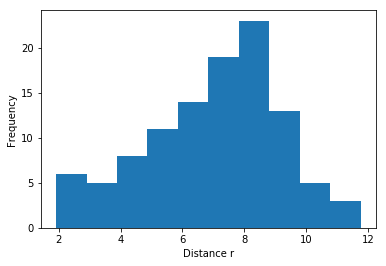

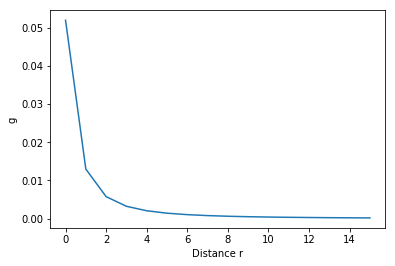

In [17]:
# plt.figure()
# plt.hist(distances[0])
# plt.xlabel('Distance r')
# plt.ylabel('Frequency')

# dr = 1
# a = func.pair_correlation(distances[0], np.arange(dr, L * 2, dr), dr, L, num_part)
# plt.figure()
# plt.plot(a)
# plt.xlabel('Distance r')
# plt.ylabel('g')
# plt.show()

https://en.wikipedia.org/wiki/Radial_distribution_function
https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html
https://gitlab.kwant-project.org/computational_physics_19/course_notes/blob/master/project%201/project.md

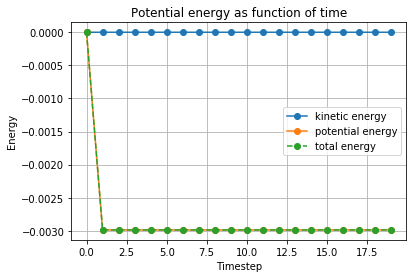

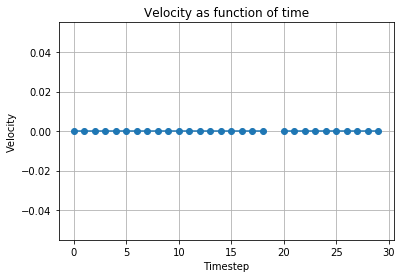

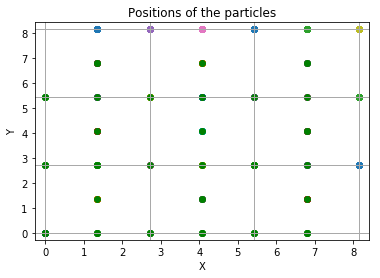

In [7]:
# # plot the potential, kinetic and total energy
# plt.title('Potential energy as function of time')
# plt.plot(range(num_time), np.sum(E_kin[:, :], axis=0), linestyle='-',  marker='o', label='kinetic energy')
# plt.plot(range(num_time), np.sum(E_pot[:, :], axis=0), linestyle='-',  marker='o', label='potential energy')    
# plt.plot(range(num_time), np.sum(E_tot[:, :], axis=0), linestyle='--', marker='o', label='total energy')
# plt.xlabel('Timestep')
# plt.ylabel('Energy')
# plt.grid()
# plt.legend()
# plt.figure()

# # plot the velocity in x-direction
# plt.title('Velocity as function of time')
# plt.plot(range(num_time), state[1, :, 3], linestyle='-', marker='o', label='velocity')
# plt.xlabel('Timestep')
# plt.ylabel('Velocity')
# plt.grid()

# # plot the positions of all particles in a new figure and plot the initial positions in green
# plt.figure()
# plt.title('Positions of the particles')
# for x in range(num_part):
#     plt.scatter(state[x, 1:, 0], state[x, 1:, 1], label='particle {}'.format(x))
#     plt.scatter(state[x, 0, 0],  state[x, 0, 1],  c='g')

# # restrict the view around the box + a small margin
# view_margin = K / 10.0
# plt.xlim(-view_margin, K * num_unit_cells_per_dim + view_margin)
# plt.ylim(-view_margin, K * num_unit_cells_per_dim + view_margin)
# plt.xlabel('X')
# plt.ylabel('Y')

# # add border lines around the box
# for x in range(num_unit_cells_per_dim + 1):
#     for y in range(num_unit_cells_per_dim + 1):
#         plt.axvline(x * K, c='darkgrey', lw = 1)
#         plt.axhline(y * K, c='darkgrey', lw = 1)

# plt.show()